# Dissecting the FICS 2021 Database

## Business Understanding

As a regular player of chess or as a new comer, one would like to know the trends in the game. So the player knows what to expect in the future games and prepare his strategy to match or even beat the trends.

We will look at a few questions and try to answer them through this notebook.

1. Is there an opening which has the more wins for a particular color?
2. Are there specific openings played at particular types of events ?
3. Is there an opening a player preferred to play?
4. Is a player more successful playing a certain color?
5. Is there an opening that different ranked players prefer from other players?

This should help the player in his preparation.

## Data Understanding

In [87]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns  # graphs
import matplotlib.pyplot as plt  # plots


### Access And Explore the data

In [88]:
# Import the dataset
# This dataset is a subset of the original dataset on Kaggle, 
# only containing the columns useful to the process, 
# Event, Date, White, Black, Result, WhiteElo, BlackElo, ECO, Movetext.

data_filename = './Chess2021.csv'
data = pd.read_csv(data_filename, parse_dates=['Date'], index_col='Unnamed: 0')

# Take a first look at the data
data.head()

,Event,Date,White,Black,Result,WhiteElo,BlackElo,ECO,Movetext
1,FICS rated blitz game,2021-12-31,Geforce,konozrout,1-0,2081,2021,C49,1. e4 Nf6 2. Nc3 e5 3. Nf3 Nc6 4. Bb5 Bb4 5. d...
2,FICS rated blitz game,2021-12-31,chesspickle,Geforce,1-0,1917,2093,D31,1. d4 d5 2. c4 c6 3. Nc3 e6 4. e3 f5 5. b3 Nf6...
3,FICS rated blitz game,2021-12-31,Geforce,chesspickle,1-0,2089,1921,B50,1. e4 c5 2. Nf3 d6 3. Bc4 Nf6 4. d3 Nc6 5. Nc3...
4,FICS rated blitz game,2021-12-31,SugarAI,Hutnik,0-1,2760,2742,C52,1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. b4 Bxb4 5. c...
5,FICS rated blitz game,2021-12-31,Hutnik,SugarAI,1/2-1/2,2742,2760,C89,1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Be7 5. O-...


#### NaN Values

We will check for `NaN` values in the dataset

In [89]:
data.isna().sum()

Event         0
Date          0
White         0
Black         0
Result        0
WhiteElo      0
BlackElo      0
ECO           0
Movetext    289
dtype: int64

`Movetext` has `NaN` values for 289 games. This means that those games were a walkover or forfeit. We cannot fill the `NaN` with any meaningful data in this case, and although the games have a result we do not want to consider them for this analysis. 

#### Encoded Values

In [90]:
data.ECO

1         C49
2         D31
3         B50
4         C52
5         C89
         ... 
118268    E00
118269    A29
118270    E16
118271    C89
118272    A29
Name: ECO, Length: 118260, dtype: object

The `ECO` column has the codes for the openings played in the games. This is useful as a data storage feature, but not useful as a visualization metric. We will need to add the intuitive names for the openings.

#### Categorical Values

The `Result` column has categorical data to indicate White Win (1-0), Draw (1/2-1/2) or a Black Win (0-1).

## Prepare Data

#### NaN Values

We will first clean up the rows with `NaN` values.

In [91]:
data.dropna(subset=['Movetext'], inplace=True)

#### Encoded Values

We will now add the intuitive names for the openings. For this we have a dataset with the `ECO` codes and the intuitive names of the openings, which we will read in. We then create a column named `ECO_Name` in the `data` dataframe with the intuitive names of the openings.

In [92]:
eco_filename = './chess-eco-reference.csv'
eco = pd.read_csv(eco_filename)

data['ECO_Name'] = data.ECO.apply(lambda x: eco[eco['ECO Code'] == x].Name.values[0])
data.head()

,Event,Date,White,Black,Result,WhiteElo,BlackElo,ECO,Movetext,ECO_Name
1,FICS rated blitz game,2021-12-31,Geforce,konozrout,1-0,2081,2021,C49,1. e4 Nf6 2. Nc3 e5 3. Nf3 Nc6 4. Bb5 Bb4 5. d...,Four Knights
2,FICS rated blitz game,2021-12-31,chesspickle,Geforce,1-0,1917,2093,D31,1. d4 d5 2. c4 c6 3. Nc3 e6 4. e3 f5 5. b3 Nf6...,Queen's Gambit Declined
3,FICS rated blitz game,2021-12-31,Geforce,chesspickle,1-0,2089,1921,B50,1. e4 c5 2. Nf3 d6 3. Bc4 Nf6 4. d3 Nc6 5. Nc3...,Sicilian
4,FICS rated blitz game,2021-12-31,SugarAI,Hutnik,0-1,2760,2742,C52,1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. b4 Bxb4 5. c...,Evans Gambit
5,FICS rated blitz game,2021-12-31,Hutnik,SugarAI,1/2-1/2,2742,2760,C89,1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Be7 5. O-...,"Ruy Lopez, Marshall"


We take a closer look at `ECO_Name`.

In [93]:
data.ECO_Name.value_counts()

Queen's Pawn Game                                              13725
Sicilian                                                        7639
Uncommon Opening                                                6733
Queen's Gambit Declined                                         4932
Queen's Gambit Declined Semi-Slav                               4274
                                                               ...  
Dutch, Ilyin-Genevsky Variation with b3                            1
Dutch, Ilyin-Genevsky Variation with Qc2                           1
Queen's Gambit Declined, Orthodox Defense, Classical, 13.de        1
Queen's Gambit Declined, Orthodox Defense, Classical               1
Benoni, Classical with ...Re8 and ...Na6                           1
Name: ECO_Name, Length: 296, dtype: int64

We see that `Uncommon Opening` was the third most played opening. This is very ironic. 

There are a group of openings classified as Uncommon Openings. So we get the names and moves of the Uncommon Openings in a dictionary.

We go through each row and check if the moves from the dictionary are in the `Movetext` column. If there is a match then the we assign the name from the dictionary to the `ECO_Name` column in the dataset.

In [136]:
# A00 is the ECO code for Uncommon Openings
# List holding the opening moves of the openings
eco_a00_moves = ['1. b4', '1. g3', '1. g4', '1. h3', '1. h3 e5 2. a3', '1. Nh3', '1. Nc3', '1. Nc3 e5 2. a3', '1. Nc3 c5 2. d4 cxd4 3. Qxd4 Nc6 4. Qh4', '1. a3', '1. a4',
                 '1. a4 e5 2. h4', '1. c3', '1. d3', '1. d3 e5 2. Nd2', '1. d3 c5 2. Nc3 Nc6 3. g3', '1. e3', '1. e3 e5 2. c4 d6 3. Nc3 Nc6 4. b3 Nf6', '1. f3', '1. f3 e5 2. Kf2', 
                 '1. h4', '1. Na3', '1. e4 d5', '1. Nf3 Nf6', '1. Nf3 c5']

# List holding the names of the openings
eco_a00_names = ['Polish Opening', 'Benko\'s Opening', 'Grob\'s Attack', 'Clemenz Opening', 'Global Opening', 'Amar Opening', 'Dunst Opening', 'Battambang Opening', 
                 'Novosibirsk Opening', 'Anderssen\'s Opening',  'Ware Opening',
                 'Crab Opening', 'Saragossa Opening', 'Mieses Opening', 'Valencia Opening', 'Venezolana Opening', 'Van\'t Kruijs Opening', 'Amsterdam Attack', 'Gedutt\'s Opening', 
                 'Hammerschlag Opening', 'Anti-Borg Opening', 'Durkin\'s Attack', 'Scandanavian Defense', 'Indian Defense', 
                 'Reti Opening']

# dict of the moves:names of the openings
eco_a00_dict = dict(zip(eco_a00_moves, eco_a00_names))

def get_eco_a00_name(row):
    '''
    Goes through eco_a00_dict and If the row.Movetext contains the openings of the dict then it
    returns the name of the opening stored against the moves keys.

    Parameters:
    row (pandas.Series): A row of the dataframe

    Returns:
    name (str): The name of the opening
    '''
    name = row.ECO_Name

    for moves in eco_a00_dict.keys():
        if moves in row.Movetext:
            name = eco_a00_dict[moves]

    return name

data.ECO_Name = data.apply(get_eco_a00_name, axis=1)
data.ECO_Name.value_counts()


Queen's Pawn Game                                       9517
Sicilian                                                5547
Dunst Opening                                           4150
Anti-Borg Opening                                       4147
Grob's Attack                                           3633
                                                        ... 
Queen's Gambit Declined, Orthodox Defense, Classical       1
Benoni, Classical with ...a6 and 10...Bg4                  1
Catalan, Open                                              1
King's Indian, Orthodox, Taimanov                          1
Benoni, Four Pawns Attack                                  1
Name: ECO_Name, Length: 313, dtype: int64

#### Categorical Values

We will convert the `Result` to one hot encoded columns using the `get_dummies` function from pandas and add it to the dataset, it would be easier perform calculations on integer data.

In [95]:
data = pd.concat([data, pd.get_dummies(data.Result).rename(
    columns={'0-1': 'Black_Win', '1-0': 'White_Win', '1/2-1/2': 'Draw'})], axis=1)
data.head()

,Event,Date,White,Black,Result,WhiteElo,BlackElo,ECO,Movetext,ECO_Name,Black_Win,White_Win,Draw
1,FICS rated blitz game,2021-12-31,Geforce,konozrout,1-0,2081,2021,C49,1. e4 Nf6 2. Nc3 e5 3. Nf3 Nc6 4. Bb5 Bb4 5. d...,Four Knights,0,1,0
2,FICS rated blitz game,2021-12-31,chesspickle,Geforce,1-0,1917,2093,D31,1. d4 d5 2. c4 c6 3. Nc3 e6 4. e3 f5 5. b3 Nf6...,Queen's Gambit Declined,0,1,0
3,FICS rated blitz game,2021-12-31,Geforce,chesspickle,1-0,2089,1921,B50,1. e4 c5 2. Nf3 d6 3. Bc4 Nf6 4. d3 Nc6 5. Nc3...,Anti-Borg Opening,0,1,0
4,FICS rated blitz game,2021-12-31,SugarAI,Hutnik,0-1,2760,2742,C52,1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. b4 Bxb4 5. c...,Ware Opening,1,0,0
5,FICS rated blitz game,2021-12-31,Hutnik,SugarAI,1/2-1/2,2742,2760,C89,1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Be7 5. O-...,"Ruy Lopez, Marshall",0,0,1


## Questions

### 1. Is there a opening which has the more wins for a particular color?

In [110]:
top_10_white_wins

Queen's Pawn Game          0.195612
Sicilian                   0.135483
Dunst Opening              0.104931
Anti-Borg Opening          0.094166
Scandanavian Defense       0.087041
Grob's Attack              0.083914
Queen's Gambit Declined    0.082787
Clemenz Opening            0.072432
Ware Opening               0.072278
Anderssen's Opening        0.071355
Name: ECO_Name, dtype: float64

Text(0, 0.5, 'Percentage')

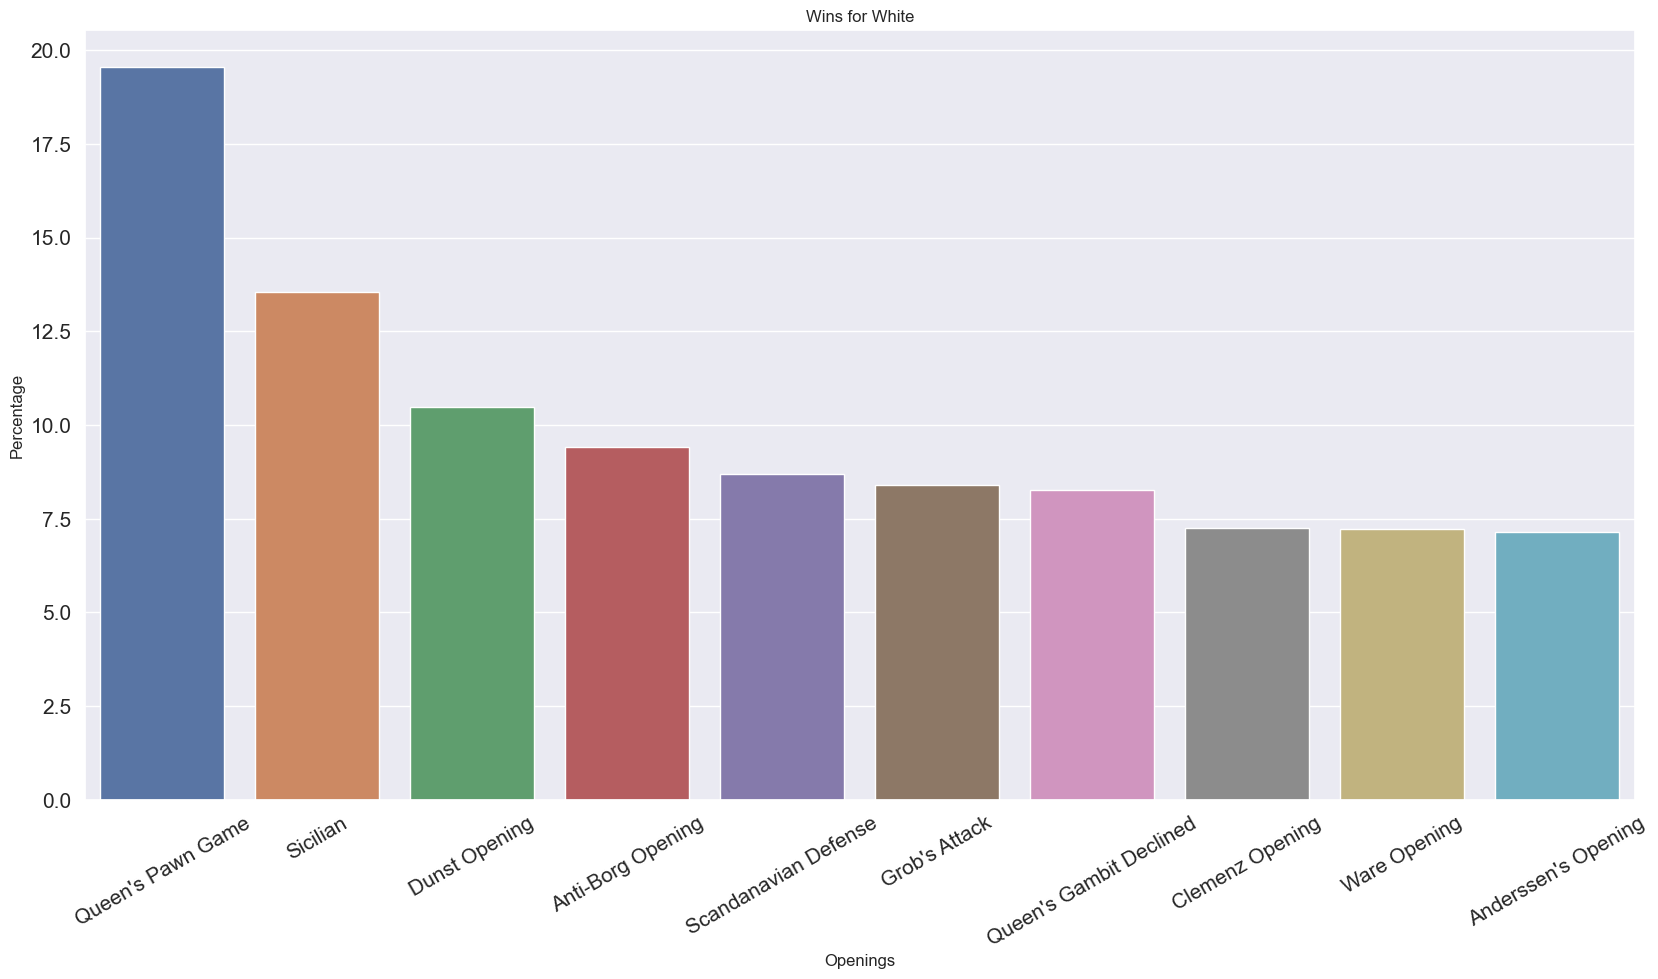

In [115]:
# Get the openings for the games where white wins and limit them to top 10
top_10_white_wins = data[data.White_Win == 1].ECO_Name.value_counts()[:10]

# Get the proportion of each count
top_10_white_wins /= top_10_white_wins.sum()
top_10_white_wins *= 100

# Plot
sns.set(rc={"figure.figsize": (20, 10)})
sns.barplot(x=top_10_white_wins.index,
            y=top_10_white_wins.values, orient='vertical')
plt.xticks(rotation=30, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Wins for White')
plt.xlabel('Openings')
plt.ylabel('Percentage')

Text(0, 0.5, 'Count')

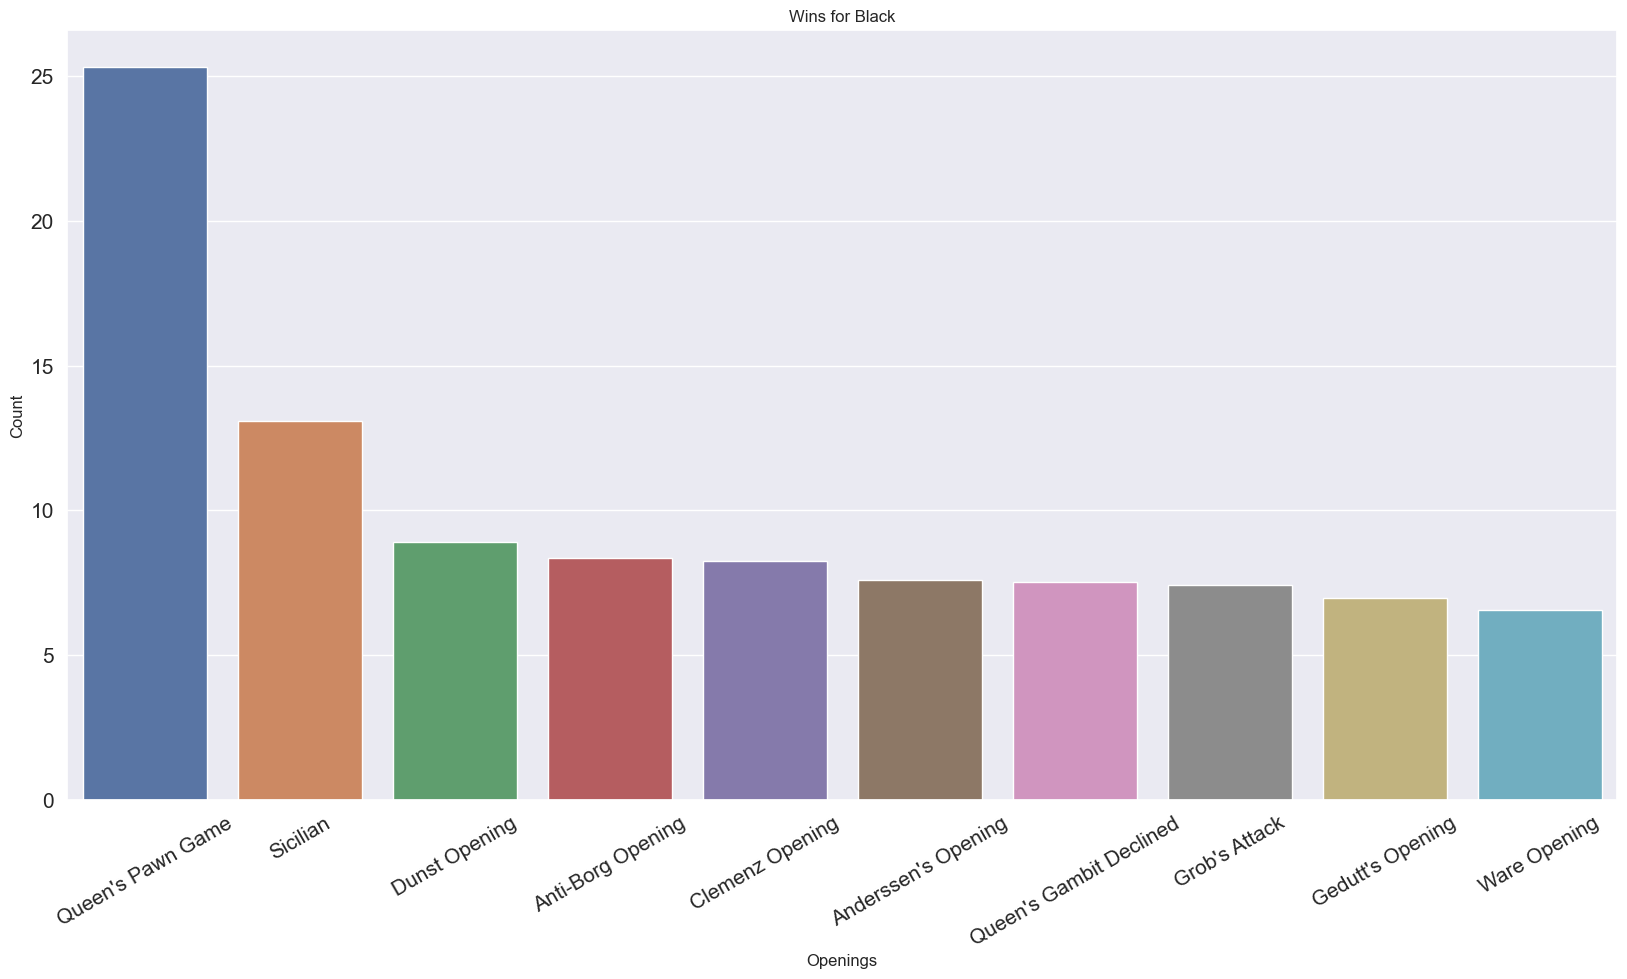

In [116]:
# Get the openings for the games where black wins and limit them to top 10
top_10_black_wins = data[data.Black_Win == 1].ECO_Name.value_counts()[:10]

# Get the proportion of each count
top_10_black_wins /= top_10_black_wins.sum()
top_10_black_wins *= 100

# Plot
sns.set(rc={"figure.figsize": (20, 10)})
sns.barplot(x=top_10_black_wins.index,
            y=top_10_black_wins.values, orient='vertical')
plt.xticks(rotation=30, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Wins for Black')
plt.xlabel('Openings')
plt.ylabel('Count')

From the above plots it is clear than the Queen's Pawn Game is most successful opening for White and Black. In fact, the first four openings are the same for both colors. The player would benefit more by playing the Scandanavian Defense and Grob's Attack more if he was White, and Clemenz Opening and Anderssen's Opening more if he was black.

### 2. Are there specific openings played at particular types of events?

The games are across 3 categories, Standard, Blitz and Lightning. There are Rated and Unrated games in each of the above categories. So there are a total of 6 categories of games. These are under the 'Event' column.

To best visualize the data we have to get it a 'wide' table format, with the Event, ECO_Name, and Count as columns, which can be plotted as grouped bar plots.

Text(0, 0.5, 'Percentage')

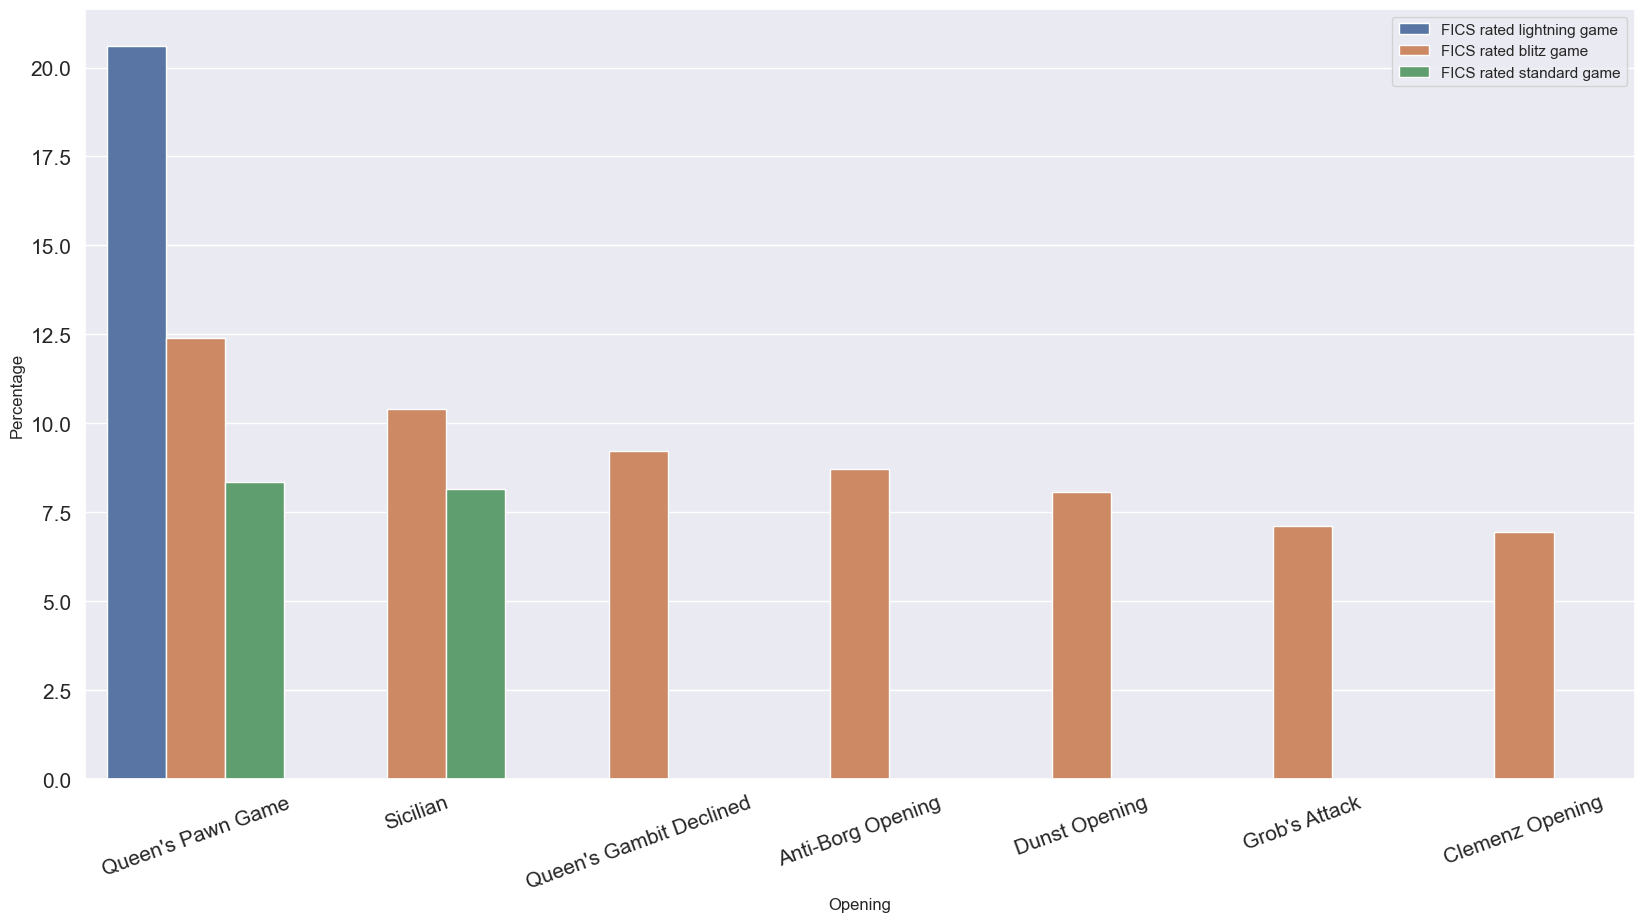

In [119]:
# Get the Top 10 openings played at different events limit it to 10
event_opening_count = data[['Event', 'ECO_Name']].value_counts()[
    :10].to_frame(name='Count').reset_index()

# Get the proportion of the each Count
event_opening_count.Count /= event_opening_count.Count.sum()
event_opening_count.Count *= 100

# Plot
sns.barplot(data=event_opening_count, x='ECO_Name', y='Count', hue='Event')

plt.legend(loc='upper right')
plt.xticks(fontsize=15, rotation=20)
plt.yticks(fontsize=15)
plt.xlabel('Opening')
plt.ylabel('Percentage')


As seen the Queen's Pawn Game and Sicilian were the most popular across the 3 types of Events.

### 3. Is there a preferred opening for a player?

We will try to find out if the players had a particular opening they preferred to play. We will limit our search to the 10 most active players on the server and their 5 most preferred openings, as black or white.

In [121]:
top_10_active_players = data[['White', 'Black']].melt(value_name='Player_Name').drop(
    columns='variable').value_counts()[:10].reset_index(name='Count')

# Dictionary with key:value pair being
# Player_Name : Dataframe of the Top 5 most played openings [Opening, Count]
player_openings = {}

for player in top_10_active_players.Player_Name:
    top_5_openings = data[(data.Black == player) | (data.White == player)].ECO_Name.value_counts()[
        :5].reset_index(name='Count').rename(columns={'index': 'Opening'})
    
    # Get the proportion of the each Count
    top_5_openings.Count /= top_5_openings.Count.sum()
    top_5_openings.Count *= 100
    
    player_openings[player] = pd.DataFrame(top_5_openings)

# Take a look at the first entry
player_openings['Geforce']


,Opening,Count
0,Sicilian,33.628132
1,Queen's Gambit Declined,21.014951
2,Giuoco Piano,15.898084
3,Uncommon King's Pawn Opening,15.498000
4,Dunst Opening,13.960834


Text(0, 0.5, 'Percentage')

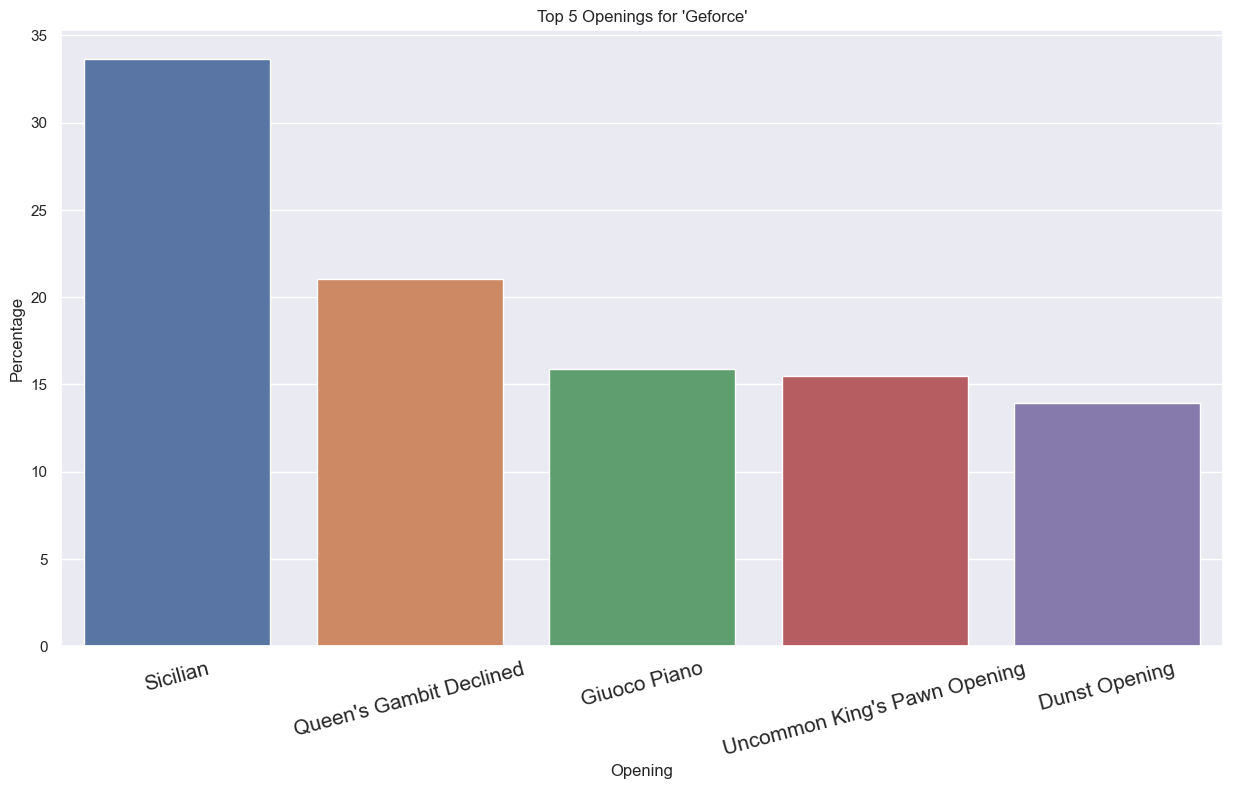

In [125]:
# Plot
sns.set(rc={"figure.figsize": (15, 8)})
sns.barplot(data=player_openings['Geforce'],
            x=player_openings['Geforce'].Opening, y=player_openings['Geforce'].Count)
plt.xticks(rotation=15, fontsize=15)
plt.title('Top 5 Openings for \'Geforce\'')
plt.ylabel('Percentage')


Player with username 'Geforce' plays the Sicilian game more than any other opening. Guioco Piano was also played which was not found the earlier plots.

### 4. Is a player more successful playing a certain color?

Players although they are profecient with either color, they do have a favourite. We will try to find out if any of the top 10 active players have more wins with one color.

Text(0.5, 0, 'Player Name')

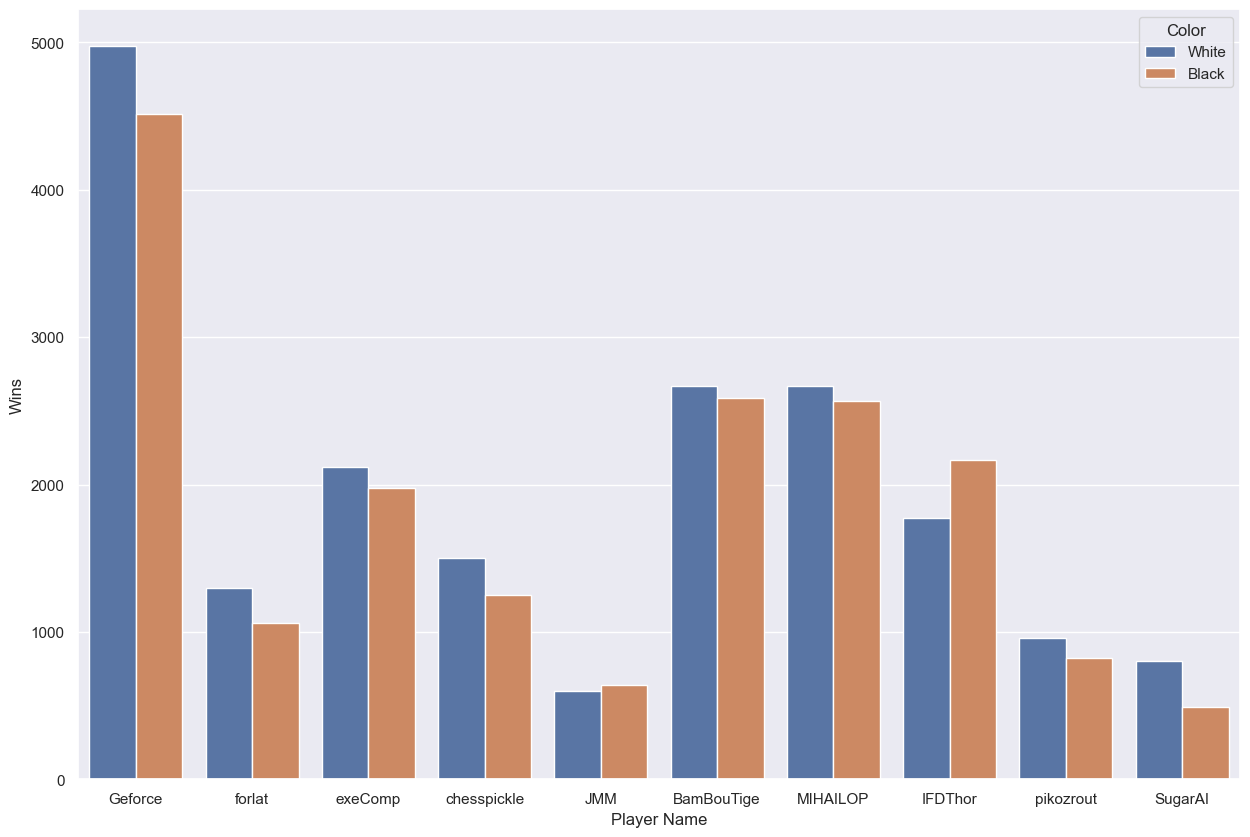

In [101]:
# list to hold player color win dictionaries
p_c_combs = []

# we use the active player dataframe from above
for player in top_10_active_players.Player_Name:
    # get the dictionary for sum of wins with white
    p_c_w = {'Player_Name': player, 'Color': 'White',
             'Wins': data[(data.White == player)]['White_Win'].sum()}
    p_c_combs.append(p_c_w)

    # get the dictionary for sum of wins with black
    p_c_b = {'Player_Name': player, 'Color': 'Black',
             'Wins': data[(data.Black == player)]['Black_Win'].sum()}
    p_c_combs.append(p_c_b)

# Create a Dataframe with the list of dictionaries
p_c_df = pd.DataFrame(p_c_combs)

# Plot
sns.set(rc={"figure.figsize": (15, 10)})
sns.barplot(data=p_c_df, x='Player_Name', y='Wins', hue='Color')
plt.xlabel('Player Name')


All the Top 10 players showed near equal skill when playing with white and black pieces. Player with username SugarAI has a stronger skillset as White since the percentage of his wins as White is almost double than wins with black

### 5. Which opening was played the most based on average ELO of the players in the game?

It is noted that the style of play of players from different skill levels vary, as do their choice of openings. It also depends on the opponents skill level.

So will a highly rated player play a different opening with a lower skill player than he would with a similarly skilled player? Is there a difference between games between high rated players and low rated players?

In [102]:
# Create a AvgElo which will contain the average ELO of the players in the games.
data['AvgElo'] = (data.WhiteElo + data.BlackElo) / 2

# Create a dataframe holding the AvgElo and the name of the openings and the count
avg_elo_df = data[['AvgElo', 'ECO_Name']].value_counts().to_frame(
    name='Count').reset_index()

print('Black Elo min max', data.BlackElo.min(), data.BlackElo.max())
print('White Elo min max', data.WhiteElo.min(), data.WhiteElo.max())
print('Avg Elo min max', data.AvgElo.min(), data.AvgElo.max())


Black Elo min max 976 3298
White Elo min max 976 3298
Avg Elo min max 2000.0 3201.5


We will create 'bucket dataframes' with different Elo ranges and limit them to the top 10 entries

Since the minimum AvgElo is 2000 we will start the bucketing from 2000 with increments of 500.

In [134]:
# dataframe for games between AvgElo 2000 and 2500
avg_elo_2000_2500_df = avg_elo_df[(avg_elo_df.AvgElo >= 2000) & (avg_elo_df.AvgElo < 2500)].drop(
    columns='AvgElo').groupby('ECO_Name', as_index=False).count().sort_values(by='Count', ascending=False)[:10]

# Get the proportion of the each Count
avg_elo_2000_2500_df.Count /= avg_elo_2000_2500_df.Count.sum()
avg_elo_2000_2500_df.Count *= 100

# dataframe for games between AvgElo 2500 and 3000
avg_elo_2500_3000_df = avg_elo_df[(avg_elo_df.AvgElo >= 2500) & (avg_elo_df.AvgElo < 3000)].drop(
    columns='AvgElo').groupby('ECO_Name', as_index=False).count().sort_values(by='Count', ascending=False)[:10]

# Get the proportion of the each Count
avg_elo_2500_3000_df.Count /= avg_elo_2500_3000_df.Count.sum()
avg_elo_2500_3000_df.Count *= 100

# dataframe for games between AvgElo 3000 and 3500
avg_elo_3000_3500_df = avg_elo_df[(avg_elo_df.AvgElo >= 3000) & (avg_elo_df.AvgElo < 3500)].drop(
    columns='AvgElo').groupby('ECO_Name', as_index=False).count().sort_values(by='Count', ascending=False)[:10]

# Get the proportion of the each Count
avg_elo_3000_3500_df.Count /= avg_elo_3000_3500_df.Count.sum()
avg_elo_3000_3500_df.Count *= 100

Text(0, 0.5, 'Percentage')

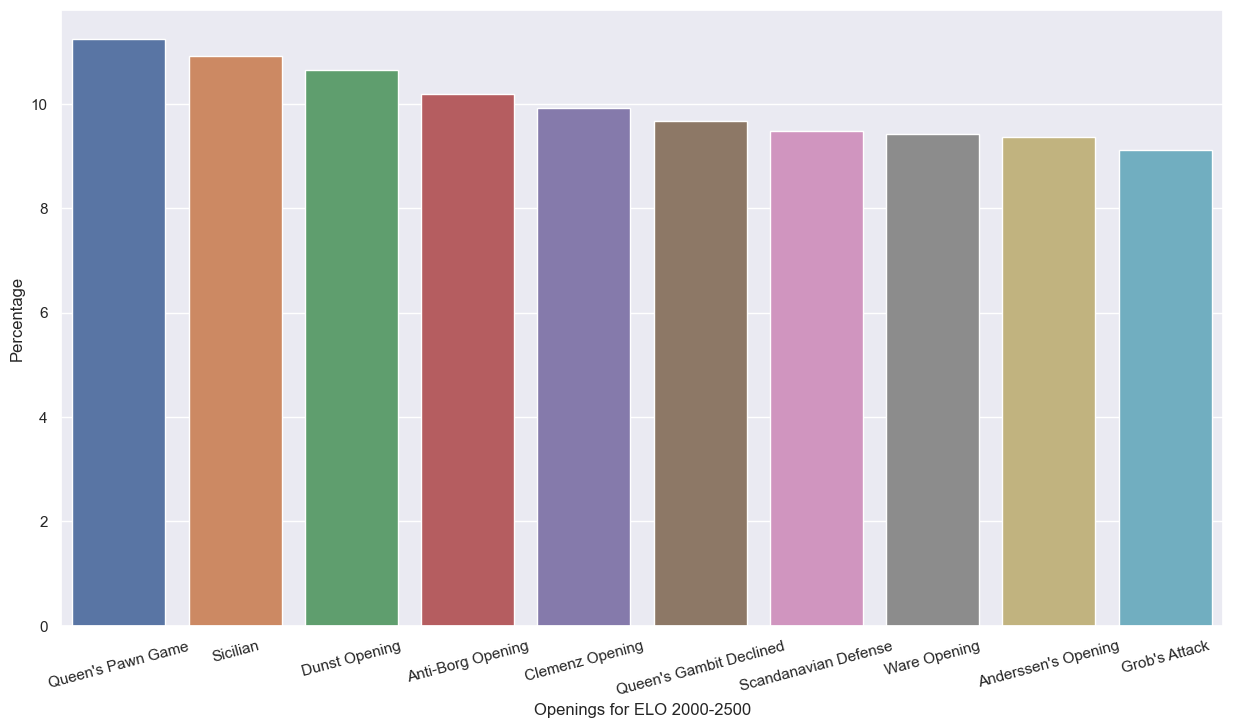

In [135]:
# Plot 2000 - 2500 data
sns.barplot(x=avg_elo_2000_2500_df.ECO_Name, y=avg_elo_2000_2500_df.Count)
plt.xticks(rotation=15)
plt.xlabel('Openings for ELO 2000-2500')
plt.ylabel('Percentage')


Text(0, 0.5, 'Percentage')

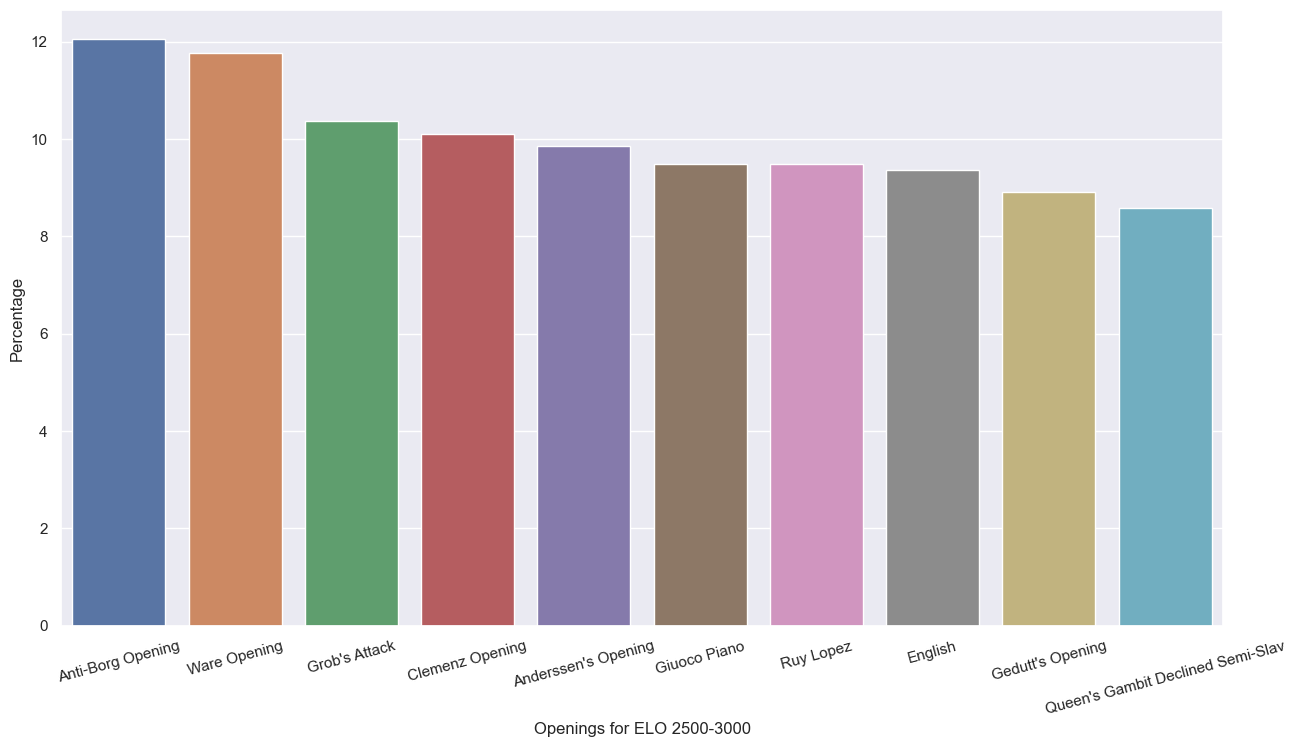

In [131]:
# Plot 2500 - 3000 data
sns.barplot(x=avg_elo_2500_3000_df.ECO_Name, y=avg_elo_2500_3000_df.Count)
plt.xticks(rotation=15)
plt.xlabel('Openings for ELO 2500-3000')
plt.ylabel('Percentage')

Text(0, 0.5, 'Percentage')

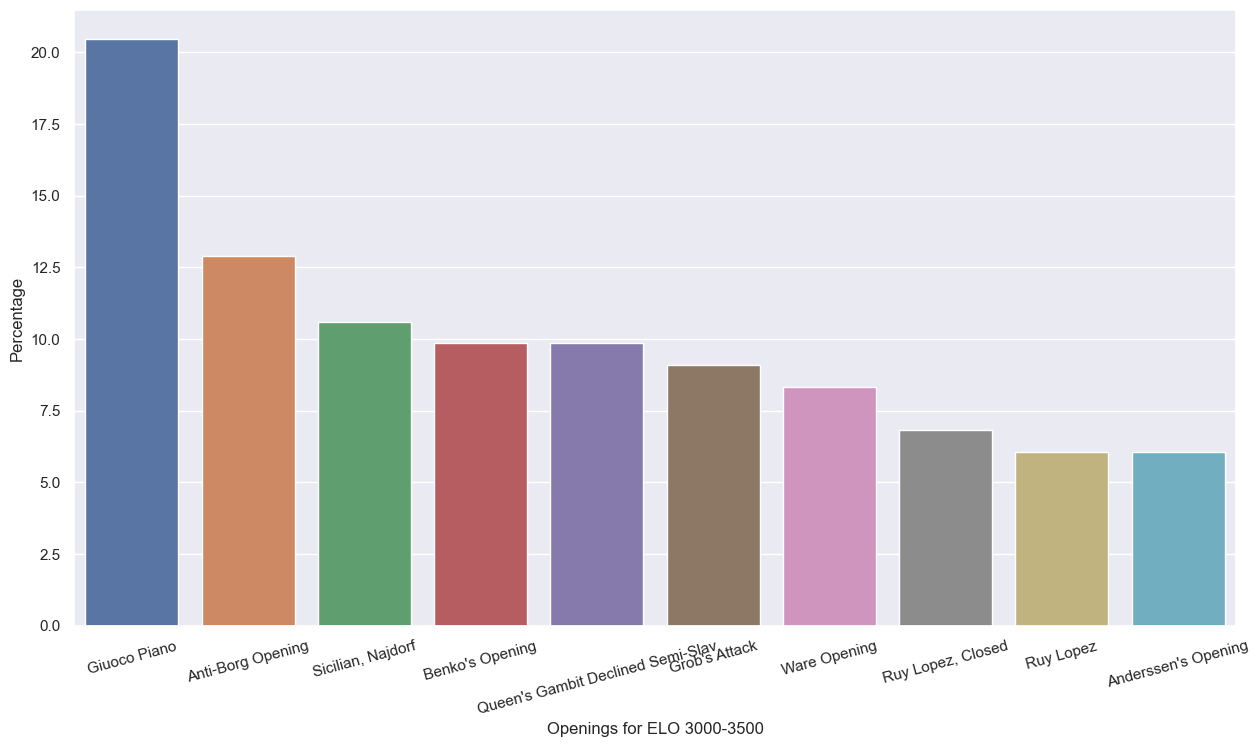

In [137]:
# Plot 3000 - 3500 data
sns.barplot(x=avg_elo_3000_3500_df.ECO_Name, y=avg_elo_3000_3500_df.Count)
plt.xticks(rotation=15)
plt.xlabel('Openings for ELO 3000-3500')
plt.ylabel('Percentage')

As seen from the 3 plots above there is a distinct change of openings played, with Guioco Piano Ruy Lopez and Siciian-Najdorf played among the highest Elo players and the Sicilian and Queen's Pawn Game played among the lowest Elo players. This shows that the Guioco Piano and Ruy Lopez are difficult to master and if done correctly the player can quickly climb the ranks.